In [1]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

%matplotlib inline

Using TensorFlow backend.


In [2]:
np.random.seed(85) # чтобы одинаково было при разных запусках


In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')



x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


C:\Users\annan\anaconda3\envs\Annnn\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\annan\anaconda3\envs\Annnn\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


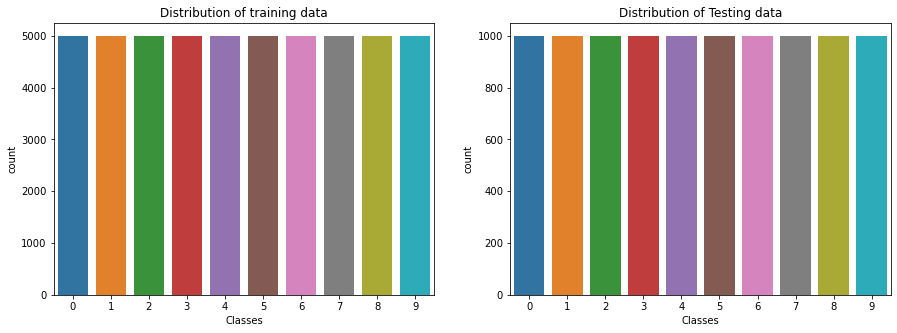

In [4]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

In [5]:
x_train[0,:,:,0]

array([[ 59,  43,  50, ..., 158, 152, 148],
       [ 16,   0,  18, ..., 123, 119, 122],
       [ 25,  16,  49, ..., 118, 120, 109],
       ...,
       [208, 201, 198, ..., 160,  56,  53],
       [180, 173, 186, ..., 184,  97,  83],
       [177, 168, 179, ..., 216, 151, 123]], dtype=uint8)

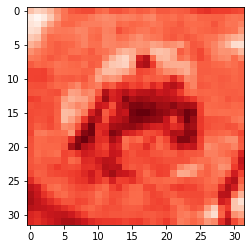

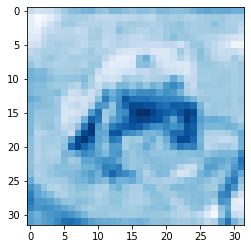

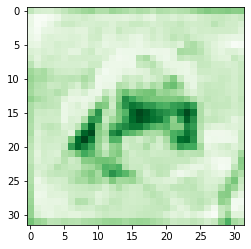

In [6]:
plt.imshow(x_train[0,:,:,0], cmap='Reds')
plt.show()
plt.imshow(x_train[0,:,:,1], cmap='Blues')
plt.show()
plt.imshow(x_train[0,:,:,2], cmap='Greens')
plt.show()

In [7]:
# Normalize the data. Before we need to connvert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


num_classes = 10  # Number of class for the dataset
# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
def make_model(counts=(32,32,64,64,512), conv_sizes=(3,3,3,3), 
               dropouts=(0.25, 0.25, 0.5),
              activations=('relu', 'relu', 'relu', 'relu', 'relu')):
    model = Sequential()
    model.add(Conv2D(counts[0], (conv_sizes[0], conv_sizes[0]), 
                     padding='same',input_shape=(32, 32, 3),
                     activation=activations[0]))
    model.add(Conv2D(counts[1], (conv_sizes[1], conv_sizes[1]), 
                     padding='same', activation=activations[1]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropouts[0]))
    
    model.add(Conv2D(counts[2], (conv_sizes[2], conv_sizes[2]), 
                     padding='same', activation=activations[2]))
    
    model.add(Conv2D(counts[3], (conv_sizes[3], conv_sizes[3]), 
                     padding='same', activation=activations[3]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropouts[1]))
    
    model.add(Flatten())
    model.add(Dense(counts[4], activation=activations[4]))
    model.add(Dropout(dropouts[2]))
    model.add(Dense(10, activation='softmax'))
    
    return model

# CONV(relu) => CONV(relu) => POOL => drop => CONV3 => CONV4 => POOL => drop => FLAT => DENSE => drop 0.5
# => 10 neurons SOFTMAX

# 8 слоев, 2 конволюции пулинг дропаут(дважды), потом flatten и еще слой с 512 нейронами для классификации

from keras.optimizers import SGD

def train_model (model, epochs = 2) :
    batch_size = 32  # The default batch size of keras.
    data_augmentation = False # не надо этого
    
    # Задаем параметры оптимизации
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  #Метрика
                  metrics=['accuracy'])
    # Обучаем модель
    model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split=0.1,
                  shuffle=True,
                  verbose=2)

In [9]:
keras.backend.clear_session()

model = make_model(counts=(10,10,20,20,50), conv_sizes=(3,3,3,3), 
                   dropouts=(0.25, 0.25, 0.5),
                   activations=('relu', 'relu', 'relu', 'relu', 'relu'))

model.summary()
train_model(model, 100)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 10)        280       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 10)        910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 10)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 10)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 20)        1820      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 20)        3620      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 20)         

Epoch 66/100
 - 36s - loss: 1.1754 - accuracy: 0.5907 - val_loss: 1.1132 - val_accuracy: 0.6300
Epoch 67/100
 - 36s - loss: 1.1669 - accuracy: 0.5873 - val_loss: 1.0005 - val_accuracy: 0.6548
Epoch 68/100
 - 36s - loss: 1.1731 - accuracy: 0.5872 - val_loss: 0.9567 - val_accuracy: 0.6760
Epoch 69/100
 - 36s - loss: 1.1758 - accuracy: 0.5870 - val_loss: 1.0468 - val_accuracy: 0.6388
Epoch 70/100
 - 36s - loss: 1.1843 - accuracy: 0.5837 - val_loss: 1.0792 - val_accuracy: 0.6274
Epoch 71/100
 - 36s - loss: 1.1753 - accuracy: 0.5883 - val_loss: 0.9803 - val_accuracy: 0.6558
Epoch 72/100
 - 36s - loss: 1.1609 - accuracy: 0.5890 - val_loss: 1.0221 - val_accuracy: 0.6424
Epoch 73/100
 - 36s - loss: 1.1755 - accuracy: 0.5877 - val_loss: 0.9738 - val_accuracy: 0.6638
Epoch 74/100
 - 36s - loss: 1.1680 - accuracy: 0.5899 - val_loss: 1.0037 - val_accuracy: 0.6544
Epoch 75/100
 - 36s - loss: 1.1700 - accuracy: 0.5873 - val_loss: 0.9561 - val_accuracy: 0.6712
Epoch 76/100
 - 36s - loss: 1.1692 - acc

In [10]:
keras.backend.clear_session()

#32 - фильтр
#32 - фильтр
#64 - нейроны в Dance
model = make_model(counts=(32,32,64,64,512), conv_sizes=(3,3,3,3), 
                   dropouts=(0.25, 0.25, 0.5),
                   activations=('relu', 'relu', 'relu', 'relu', 'relu'))

model.summary()
train_model(model, 100) #модель, эпохи

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)         

Epoch 65/100
 - 122s - loss: 0.4753 - accuracy: 0.8484 - val_loss: 0.7928 - val_accuracy: 0.7660
Epoch 66/100
 - 122s - loss: 0.4655 - accuracy: 0.8498 - val_loss: 0.8205 - val_accuracy: 0.7742
Epoch 67/100
 - 122s - loss: 0.4651 - accuracy: 0.8507 - val_loss: 0.8104 - val_accuracy: 0.7698
Epoch 68/100
 - 122s - loss: 0.4556 - accuracy: 0.8515 - val_loss: 0.8273 - val_accuracy: 0.7638
Epoch 69/100
 - 122s - loss: 0.4518 - accuracy: 0.8551 - val_loss: 0.7909 - val_accuracy: 0.7622
Epoch 70/100
 - 122s - loss: 0.4626 - accuracy: 0.8507 - val_loss: 0.8493 - val_accuracy: 0.7466
Epoch 71/100
 - 122s - loss: 0.4702 - accuracy: 0.8495 - val_loss: 0.8010 - val_accuracy: 0.7720
Epoch 72/100
 - 122s - loss: 0.4691 - accuracy: 0.8520 - val_loss: 0.8171 - val_accuracy: 0.7738
Epoch 73/100
 - 122s - loss: 0.4641 - accuracy: 0.8526 - val_loss: 0.8058 - val_accuracy: 0.7700
Epoch 74/100
 - 1295s - loss: 0.4647 - accuracy: 0.8519 - val_loss: 0.8538 - val_accuracy: 0.7474
Epoch 75/100
 - 128s - loss: 